In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn import preprocessing
import warnings
import lightgbm as lgb

In [ ]:
df = pd.read_csv("mid.csv",encoding ='UTF-8')

In [ ]:
df = df.drop(["種類", "都道府県名"], axis=1)

In [ ]:
df["今後の利用目的"].value_counts()

住宅     41803
その他     2106
事務所      673
店舗       220
Name: 今後の利用目的, dtype: int64

In [ ]:
df["取引の事情等"].value_counts()

調停・競売等             1608
関係者間取引              155
瑕疵有りの可能性             12
その他事情有り               8
他の権利・負担付き             5
関係者間取引、調停・競売等         1
関係者間取引、瑕疵有りの可能性       1
Name: 取引の事情等, dtype: int64

In [ ]:
df = df.drop(["今後の利用目的", "取引の事情等"], axis=1)

In [ ]:
pip install featuretools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.7/555.7 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.7/230.7 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 16.9 MB/s eta 0:00:00
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [ ]:
import featuretools as ft

In [ ]:
es = ft.EntitySet(id='example') 

es.add_dataframe(dataframe_name='locations', 
                         dataframe=df, 
                         index='name')  
trans_primitives=['add_numeric', 'multiply_numeric']
agg_primitives=[]

feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_dataframe_name='locations',
                                      trans_primitives=trans_primitives,
                                      agg_primitives=agg_primitives,
                                      max_depth=1)

/usr/local/lib/python3.8/dist-packages/featuretools/entityset/entityset.py:1906: UserWarning: index name not found in dataframe, creating new integer column
  warnings.warn(


In [ ]:
feature_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86538 entries, 0 to 86537
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   市区町村名                 86538 non-null  category
 1   地区名                   86535 non-null  category
 2   最寄駅：名称                86393 non-null  category
 3   最寄駅：距離（分）             84807 non-null  Int64   
 4   取引価格（総額）              86538 non-null  int64   
 5   間取り                   81421 non-null  category
 6   面積（㎡）                 86538 non-null  float64 
 7   建物の構造                 85427 non-null  category
 8   用途                    78688 non-null  category
 9   都市計画                  85829 non-null  category
 10  建ぺい率（％）               85367 non-null  Int64   
 11  容積率（％）                85367 non-null  Int64   
 12  取引時点                  86538 non-null  float64 
 13  改装                    75347 non-null  category
 14  築年数                   85649 non-null  Int64   
 15  取引

In [ ]:
feature_matrix.shape

(86538, 57)

In [ ]:
feature_matrix = feature_matrix.drop(["取引価格（総額） + 取引時点",
                                      "取引価格（総額） + 容積率（％）",
                                      "取引価格（総額） + 建ぺい率（％）",
                                      "取引価格（総額） + 最寄駅：距離（分）",
                                      "取引価格（総額） + 築年数",
                                      "取引価格（総額） + 面積（㎡）",       
                                      "取引価格（総額） * 取引時点",
                                      "取引価格（総額） * 容積率（％）",
                                      "取引価格（総額） * 建ぺい率（％）",
                                      "取引価格（総額） * 最寄駅：距離（分）",
                                      "取引価格（総額） * 築年数",
                                      "取引価格（総額） * 面積（㎡）"], axis=1)


In [ ]:
feature_matrix.isnull().sum()

市区町村名                      0
地区名                        3
最寄駅：名称                   145
最寄駅：距離（分）               1731
取引価格（総額）                   0
間取り                     5117
面積（㎡）                      0
建物の構造                   1111
用途                      7850
都市計画                     709
建ぺい率（％）                 1171
容積率（％）                  1171
取引時点                       0
改装                     11191
築年数                      889
取引時点 + 容積率（％）           1171
取引時点 + 建ぺい率（％）          1171
取引時点 + 最寄駅：距離（分）        1731
取引時点 + 築年数               889
取引時点 + 面積（㎡）               0
容積率（％） + 建ぺい率（％）        1171
容積率（％） + 最寄駅：距離（分）      2480
容積率（％） + 築年数            1910
容積率（％） + 面積（㎡）          1171
建ぺい率（％） + 最寄駅：距離（分）     2480
建ぺい率（％） + 築年数           1910
建ぺい率（％） + 面積（㎡）         1171
最寄駅：距離（分） + 築年数         2523
最寄駅：距離（分） + 面積（㎡）       1731
築年数 + 面積（㎡）              889
取引時点 * 容積率（％）           1171
取引時点 * 建ぺい率（％）          1171
取引時点 * 最寄駅：距離（分）        1731
取引時点 * 築年数               889
取引時点 * 面積（㎡）  

In [ ]:
feature_matrix = feature_matrix.dropna()
feature_matrix.isnull().sum()

市区町村名                  0
地区名                    0
最寄駅：名称                 0
最寄駅：距離（分）              0
取引価格（総額）               0
間取り                    0
面積（㎡）                  0
建物の構造                  0
用途                     0
都市計画                   0
建ぺい率（％）                0
容積率（％）                 0
取引時点                   0
改装                     0
築年数                    0
取引時点 + 容積率（％）          0
取引時点 + 建ぺい率（％）         0
取引時点 + 最寄駅：距離（分）       0
取引時点 + 築年数             0
取引時点 + 面積（㎡）           0
容積率（％） + 建ぺい率（％）       0
容積率（％） + 最寄駅：距離（分）     0
容積率（％） + 築年数           0
容積率（％） + 面積（㎡）         0
建ぺい率（％） + 最寄駅：距離（分）    0
建ぺい率（％） + 築年数          0
建ぺい率（％） + 面積（㎡）        0
最寄駅：距離（分） + 築年数        0
最寄駅：距離（分） + 面積（㎡）      0
築年数 + 面積（㎡）            0
取引時点 * 容積率（％）          0
取引時点 * 建ぺい率（％）         0
取引時点 * 最寄駅：距離（分）       0
取引時点 * 築年数             0
取引時点 * 面積（㎡）           0
容積率（％） * 建ぺい率（％）       0
容積率（％） * 最寄駅：距離（分）     0
容積率（％） * 築年数           0
容積率（％） * 面積（㎡）         0
建ぺい率（％） * 最寄駅：距離（分）    0


In [ ]:
feature_matrix.shape

(65370, 45)

In [ ]:
def data_preprocess(df):
  cat_fetures = ["市区町村名", "地区名", "最寄駅：名称", "間取り", "建物の構造", "用途", "都市計画", "改装"]
  for col in cat_fetures:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(df[col])
    lbl.transform(df[col])
    df[col] = lbl.transform(df[col])
  return df

feature_matrix =data_preprocess(feature_matrix)

In [ ]:
X = feature_matrix.drop("取引価格（総額）", axis=1)
y = feature_matrix["取引価格（総額）"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
model = LinearRegression() 
model.fit(X_train, y_train)             
y_pred = model.predict(X_test)                                   

In [ ]:
print("平均二乗誤差 (MSE): ", mean_squared_error(y_test, y_pred)) 
print("二乗平均平方根誤差(RMSE): ", mean_squared_error(y_test, y_pred, squared=False)) 
print("平均絶対誤差 (MAE): ", mean_absolute_error(y_test, y_pred)) 
print("決定係数(R2): ", r2_score(y_test, y_pred)) 
print("平均絶対誤差率(MAPE): ", np.mean(np.abs((y_pred - y_test) / y_test)) * 100) 

平均二乗誤差 (MSE):  30523098029306.727
二乗平均平方根誤差(RMSE):  5524771.310136441
平均絶対誤差 (MAE):  4217789.222480547
決定係数(R2):  0.6646073829056789
平均絶対誤差率(MAPE):  172.27180488953232


In [ ]:
print("学習データに対する決定係数(R2): ", model.score(X_train ,y_train)) 
print("学習データに対する決定係数(R2): ", model.score(X_test, y_test)) 

学習データに対する決定係数(R2):  0.6498311050316787
学習データに対する決定係数(R2):  0.6646073829056789


<Figure size 720x720 with 0 Axes>

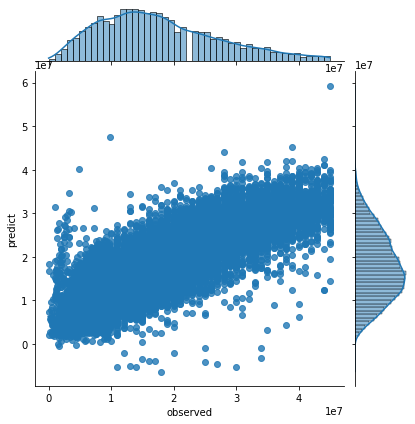

In [ ]:
plot_data = pd.DataFrame()
plot_data['observed'] = y_test[:]
plot_data['predict'] = y_pred[:]
plt.figure(figsize=(10,10))
sns.jointplot(x='observed', y='predict', data=plot_data, kind='reg')
plt.show()

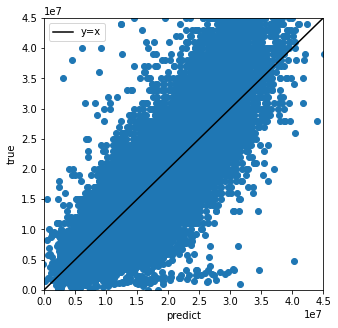

In [ ]:
plt.figure(figsize=(5, 5)) 
plt.plot([0,y_test.max()], [0,y_test.max()], label="y=x", color="black")
plt.scatter(y_pred, y_test)
plt.legend()
plt.xlim(0, y_test.max())
plt.ylim(0, y_test.max())
plt.xlabel("predict")
plt.ylabel("true")
plt.show()

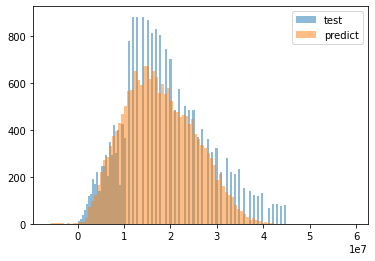

In [ ]:
plt.hist(y_test, bins=100, alpha=0.5, label="test")
plt.hist(y_pred, bins=100, alpha=0.5, label="predict")
plt.legend()
plt.show()